In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

detector_params = cv2.SimpleBlobDetector_Params()
detector_params.filterByArea = True
detector_params.maxArea = 100
detector_params.filterByCircularity = False
detector = cv2.SimpleBlobDetector_create(detector_params)
eye_detector = cv2.SimpleBlobDetector_create(detector_params)

['10.jpeg', 'asian1.jpg', 'asian2.jpg', 'asian3.jpg', '.DS_Store', '11.jpeg', 'asian11.jpg', 'asian7.jpeg', 'asian10.jpeg', '6.jpeg', 'asian6.jpeg', '8.jpeg', 'asian9.jpeg', 'asian12.jpeg', 'asian5.jpeg', '14.jpeg', '15.jpeg', 'asian4.jpeg', 'asian13.jpeg', '5.jpeg', 'asian8.jpeg', '9.jpeg', '4.jpg', 'asian14.jpeg', '12.jpeg', '7.png', '2.jpg', '3.jpg', '1.jpg', '13.jpeg', 'asian15.jpeg']


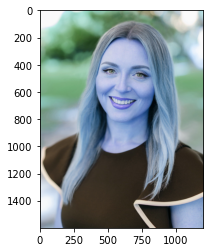

In [389]:
images = os.listdir("images/")
print(images)
#img = cv2.imread('images/asian_female_headshot.jpg')
# img = cv2.imread('test-img.png')
# img = cv2.imread('headshot.jpeg')
# img = cv2.imread('black-man.jpeg')
#img = cv2.imread('white-woman.jpeg')
#img = cv2.imread('images/white-man.jpeg')
filename = '11.jpeg'
img = cv2.imread('images/' + filename)

plt.imshow(img)

ValueError: x and y can be no greater than 2-D, but have shapes (564,) and (564, 564, 3)

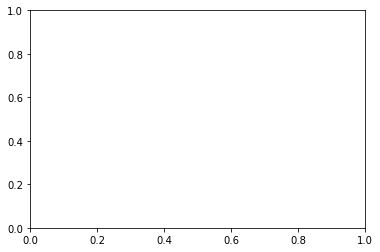

In [390]:
face_coords = detect_face_coords(img, face_cascade)
fx, fy, fw, fh = face_coords
cv2.rectangle(img, (fx, fy), (fx + fw, fy + fh), (255, 255, 0), 2)

face_frame = img[fy : fy + fh, fx : fx + fw]

left_eye_coords, right_eye_coords = detect_eyes_coords(face_frame, eye_cascade)
lx, ly, lw, lh = left_eye_coords
rx, ry, rw, rh = right_eye_coords
cv2.rectangle(face_frame, (lx, ly), (lx + lw, ly + lh), (0, 225, 255), 2)
cv2.rectangle(face_frame, (rx, ry), (rx + rw, ry + rh), (0, 225, 255), 2)

left_eye_frame = face_frame[ly : ly + lh, lx : lx + lw]
right_eye_frame = face_frame[ry : ry + rh, rx : rx + rw]
eye_frames = [left_eye_frame, right_eye_frame]
plt.plot(face_frame)

In [381]:
from utils import detect_face_coords, detect_eyes_coords

def show_frames(img):
    face_coords = detect_face_coords(img, face_cascade)
    fx, fy, fw, fh = face_coords
    cv2.rectangle(img, (fx, fy), (fx + fw, fy + fh), (255, 255, 0), 2)

    face_frame = img[fy : fy + fh, fx : fx + fw]

    left_eye_coords, right_eye_coords = detect_eyes_coords(face_frame, eye_cascade)
    lx, ly, lw, lh = left_eye_coords
    rx, ry, rw, rh = right_eye_coords
    cv2.rectangle(face_frame, (lx, ly), (lx + lw, ly + lh), (0, 225, 255), 2)
    cv2.rectangle(face_frame, (rx, ry), (rx + rw, ry + rh), (0, 225, 255), 2)

    left_eye_frame = face_frame[ly : ly + lh, lx : lx + lw]
    right_eye_frame = face_frame[ry : ry + rh, rx : rx + rw]
    eye_frames = [left_eye_frame, right_eye_frame]
    return eye_frames

In [386]:
from utils import remove_eyebrows, find_eye_keypoints, find_best_threshold, shift_contour_inside_eye, is_contour_circular

def show_eyes(eye_frames):
    for eye in eye_frames:
        eye = remove_eyebrows(eye)
        gray_frame = cv2.cvtColor(eye, cv2.COLOR_BGR2GRAY)
        gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)

        threshold = find_best_threshold(gray_frame)
        _, eye_img = cv2.threshold(gray_frame, threshold, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(eye_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours = contours[1:] # removes the window frame contour
        contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
        '''largest_contour = contours[0]
        largest_contour = shift_contour_inside_eye(eye, largest_contour)
        contours[0] = largest_contour'''


        # center contour point
        '''center_x = np.mean(contour_coords[:, 0])
        center_y = np.mean(contour_coords[:, 1])
        cv2.circle(eye, (int(center_x), int(center_y)), 10, (0, 0, 255), -1)'''

        if len(contours) > 0:
            largest_contour = contours[0]
            if is_contour_circular(largest_contour):
                print("is circular")
                pupil_img = cv2.drawContours(eye, contours, 0, (0,0,255), 3)
            else:
                largest_contour = contours[0]
                contour_coords = largest_contour.reshape(-1, 2)
                center_x = np.mean(contour_coords[:, 0])
                center_y = np.mean(contour_coords[:, 1])
                pupil_img = cv2.circle(eye, (int(center_x), int(center_y)), int(eye.shape[0]/7), (0, 0, 255), -1)

    return pupil_img

In [387]:
for filename in images:
    img = cv2.imread('images/' + filename)
    eye_frames = show_frames(img)
    pupils = show_eyes(eye_frames)
    plt.imsave("outputs/output_" + filename, face_frame)

[[[  0 225 255]
  [  0 225 255]
  [172 184 208]
  ...
  [147 167 215]
  [146 165 216]
  [  0 225 255]]

 [[  0 225 255]
  [  0 225 255]
  [171 183 211]
  ...
  [144 163 214]
  [143 164 216]
  [  0 225 255]]

 [[  0 225 255]
  [  0 225 255]
  [167 181 210]
  ...
  [136 157 209]
  [135 157 209]
  [  0 225 255]]

 ...

 [[  0 225 255]
  [  0 225 255]
  [184 195 223]
  ...
  [192 194 228]
  [195 198 229]
  [  0 225 255]]

 [[  0 225 255]
  [  0 225 255]
  [184 195 223]
  ...
  [192 195 226]
  [195 199 228]
  [  0 225 255]]

 [[  0 225 255]
  [  0 225 255]
  [  0 225 255]
  ...
  [  0 225 255]
  [  0 225 255]
  [  0 225 255]]]
[[[  0 225 255]
  [  0 225 255]
  [130 152 204]
  ...
  [167 178 206]
  [167 178 208]
  [  0 225 255]]

 [[  0 225 255]
  [  0 225 255]
  [134 155 210]
  ...
  [161 172 200]
  [168 179 209]
  [  0 225 255]]

 [[  0 225 255]
  [  0 225 255]
  [140 161 216]
  ...
  [131 142 170]
  [152 163 193]
  [  0 225 255]]

 ...

 [[  0 225 255]
  [  0 225 255]
  [192 200 229]
  ..

error: OpenCV(4.9.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


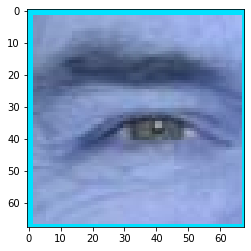

In [323]:
plt.imshow(eye_frames[0])

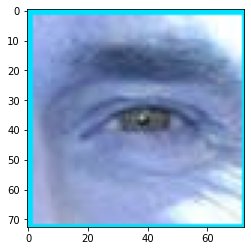

In [324]:
plt.imshow(eye_frames[1])

In [113]:
'''cap = cv2.VideoCapture(0)
while True:
    _, frame = cap.read()
    face_coords = detect_face_coords(frame, face_cascade)
    fx, fy, fw, fh = face_coords
    if np.sum(face_coords) > 0:
        
        cv2.rectangle(frame, (fx, fy), (fx + fw, fy + fh), (255, 255, 0), 2)
        face_frame = frame[fy : fy + fh, fx : fx + fw]

        left_eye_coords, right_eye_coords = detect_eyes_coords(face_frame, eye_cascade)
        lx, ly, lw, lh = left_eye_coords
        rx, ry, rw, rh = right_eye_coords
        if np.sum(left_eye_coords) > 0 and np.sum(right_eye_coords) > 0:
            cv2.rectangle(face_frame, (lx, ly), (lx + lw, ly + lh), (0, 225, 255), 2)
            cv2.rectangle(face_frame, (rx, ry), (rx + rw, ry + rh), (0, 225, 255), 2)

            left_eye_frame = face_frame[ly : ly + lh, lx : lx + lw]
            right_eye_frame = face_frame[ry : ry + rh, rx : rx + rw]
            eye_frames = [left_eye_frame, right_eye_frame]

            for eye in eye_frames:
                eye = remove_eyebrows(eye)
                gray_frame = cv2.cvtColor(eye, cv2.COLOR_BGR2GRAY)
                gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)

                threshold = find_best_threshold(gray_frame)
                _, eye_img = cv2.threshold(gray_frame, threshold, 255, cv2.THRESH_BINARY)
                contours, _ = cv2.findContours(eye_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                contours = contours[1:] # removes the window frame contour
                contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)

                if contours:
                    cv2.drawContours(eye, contours, 0, (0,255,0), 3)
        
        cv2.imshow('Iris Detection', frame[fy : fy + fh, fx : fx + fw])
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()'''

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - Can't parse 'center'. Sequence item with index 0 has a wrong type
>  - Can't parse 'center'. Sequence item with index 0 has a wrong type
